In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
from PIL import Image, ImageDraw

In [3]:
train = torchvision.datasets.OxfordIIITPet(root=".", split="trainval", target_types="segmentation", download=True)
test = torchvision.datasets.OxfordIIITPet(root=".", split="test", target_types="segmentation", download=True)

In [4]:
from typing import Any, Tuple


class AugmentedDataset(torchvision.datasets.OxfordIIITPet):
    def __init__(
            self,
            root: str,
            split: str,
            target_types = "segmentation",
            download = False,
            pre_transform = None,
            post_transform = None,
            pre_target_transform=None,
            post_target_transform=None,
            common_transform=None,
    ):
        super().__init__(
            root=root,
            split=split,
            target_types=target_types,
            download=download,
            transform=pre_transform,
            target_transform=pre_target_transform
        )
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform
        self.common_transform = common_transform
    
    def __len__(self):
        return super().__len__()
    
    def __getitem__(self, idx: int):
        input, target = super().__getitem__(idx)

        if self.common_transform is not None:
            both = torch.cat([input, target], dim=0)
            both = self.common_transform(both)
            (input, target) = torch.split(both, 3, dim=0)
        
        if self.post_transform is not None:
            input = self.post_transform(input)
        
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)
        
        return (input, target)

In [5]:
# Create a tensor for a segmentation trimap.
# Input: Float tensor with values in [0.0 .. 1.0]
# Output: Long tensor with values in {0, 1, 2}
def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x

def args_to_dict(**kwargs):
    return kwargs

transform_dict = args_to_dict(
    pre_transform=transforms.ToTensor(),
    pre_target_transform=transforms.ToTensor(),
    common_transform=transforms.Compose([
        transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.NEAREST),
        # Random Horizontal Flip as data augmentation.
        transforms.RandomHorizontalFlip(p=0.5),
    ]),
    post_transform=transforms.Compose([
        # Color Jitter as data augmentation.
        transforms.ColorJitter(contrast=0.3),
    ]),
    post_target_transform=transforms.Compose([
        transforms.Lambda(tensor_trimap),
    ]),
)

In [6]:
# Create the train and test instances of the data loader for the
# Oxford IIIT Pets dataset with random augmentations applied.
# The images are resized to 128x128 squares, so the aspect ratio
# will be chaged. We use the nearest neighbour resizing algorithm
# to avoid disturbing the pixel values in the provided segmentation
# mask.
pets_train = AugmentedDataset(
    root=".",
    split="trainval",
    target_types="segmentation",
    download=False,
    **transform_dict,
)
pets_test = AugmentedDataset(
    root=".",
    split="test",
    target_types="segmentation",
    download=False,
    **transform_dict,
)

pets_train_loader = torch.utils.data.DataLoader(
    pets_train,
    batch_size=64,
    shuffle=True,
)
pets_test_loader = torch.utils.data.DataLoader(
    pets_test,
    batch_size=21,
    shuffle=True,
)


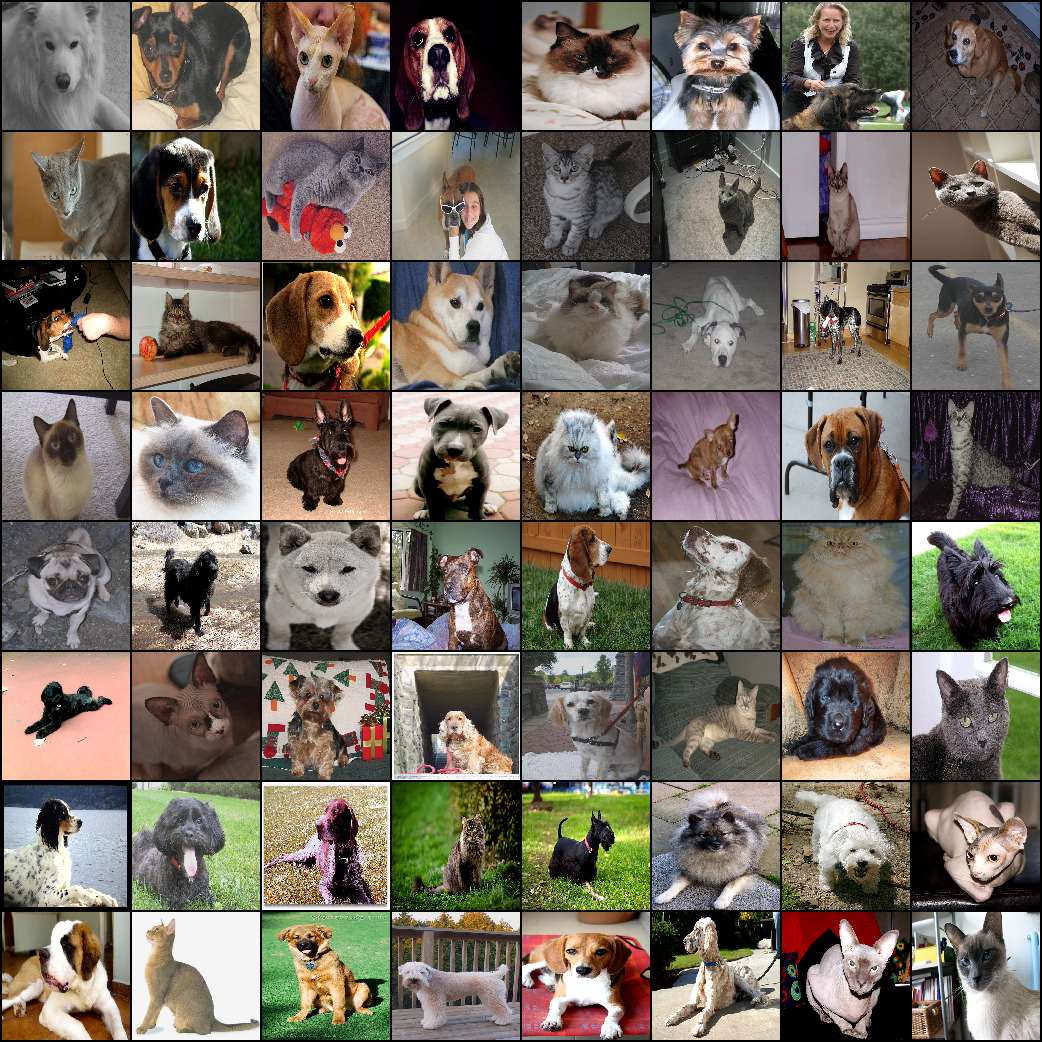

In [7]:
import torch.utils


inp, out = next(iter(pets_train_loader))
grid = torchvision.utils.make_grid(inp, nrow=8)
transforms.ToPILImage()(grid)

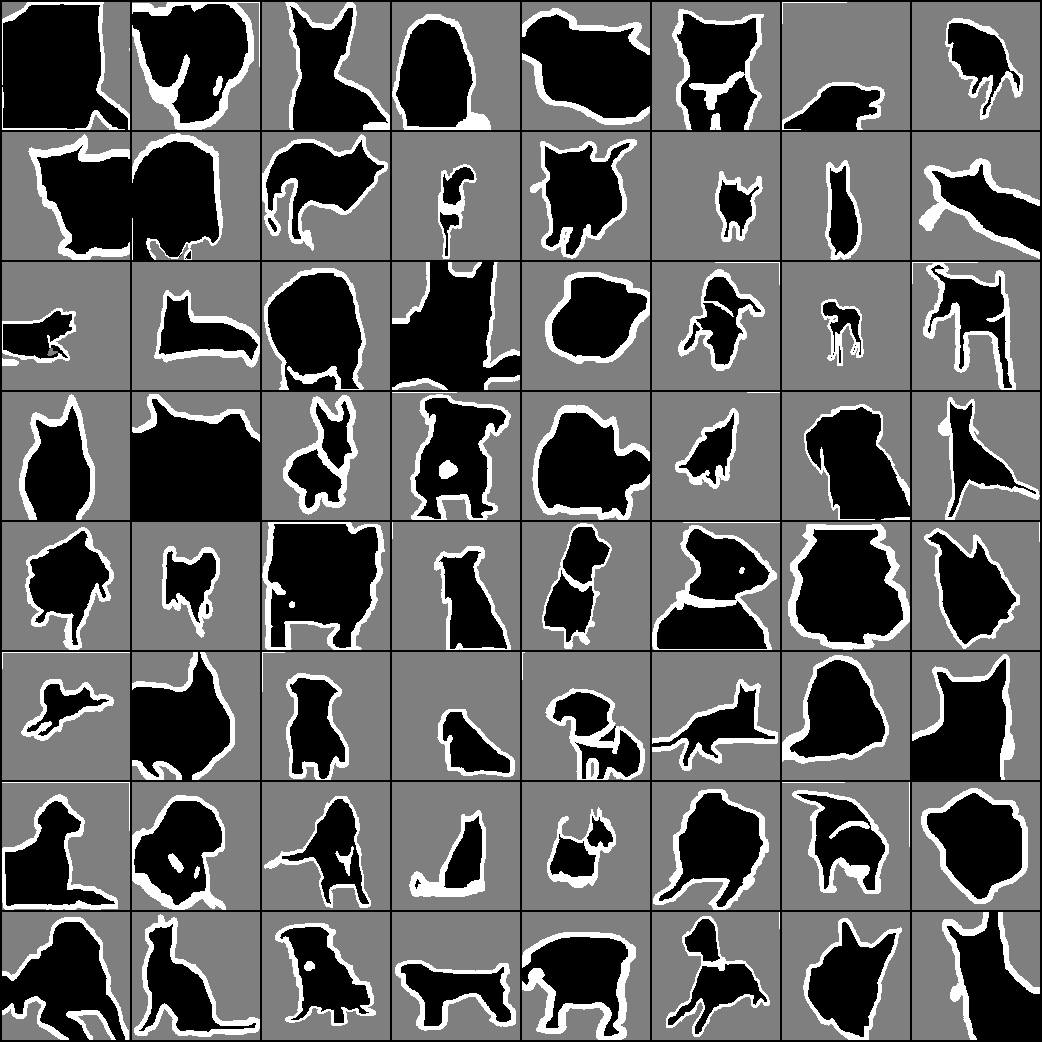

In [8]:
grid2 = torchvision.utils.make_grid(out / 2, nrow=8)
transforms.ToPILImage()(grid2)

In [9]:
class TwoConv(nn.Module):
    def __init__(self, inf, outf, kernel_size):
        super().__init__()
        self.con = nn.Sequential(
            nn.Conv2d(in_channels=inf, out_channels=outf, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(outf),
            nn.ReLU(),
            nn.Conv2d(in_channels=outf, out_channels=outf, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(outf),
            nn.ReLU(),
        )
        self.mp = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
    
    def forward(self, x):
        x = self.con(x)
        shp = x.shape
        x, indices = self.mp(x)
        return x, indices, shp

In [10]:
class ThreeConv(nn.Module):
    def __init__(self, inf, outf, kernel_size):
        super().__init__()
        self.con = nn.Sequential(
            nn.Conv2d(in_channels=inf, out_channels=outf, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(outf),
            nn.ReLU(),
            nn.Conv2d(in_channels=outf, out_channels=outf, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(outf),
            nn.ReLU(),
            nn.Conv2d(in_channels=outf, out_channels=outf, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(outf),
            nn.ReLU(),
        )
        self.mp = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
    
    def forward(self, x):
        x = self.con(x)
        shp = x.shape
        x, indices = self.mp(x)
        return x, indices, shp

In [11]:
class ThreeUpConv(nn.Module):
    def __init__(self, inf, outf, kernel_size):
        super().__init__()
        self.con = nn.Sequential(
            nn.Conv2d(in_channels=inf, out_channels=inf, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(inf),
            nn.ReLU(),
            nn.Conv2d(in_channels=inf, out_channels=inf, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(inf),
            nn.ReLU(),
            nn.Conv2d(in_channels=inf, out_channels=outf, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(outf),
            nn.ReLU(),
        )
        self.mp = nn.MaxUnpool2d(kernel_size=2)
    
    def forward(self, x, indexes, output_size):
        x = self.mp(x, indexes, output_size=output_size)
        x = self.con(x)
        return x

In [12]:
class TwoUpConv(nn.Module):
    def __init__(self, inf, outf, kernel_size):
        super().__init__()
        self.con = nn.Sequential(
            nn.Conv2d(in_channels=inf, out_channels=inf, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(inf),
            nn.ReLU(),
            nn.Conv2d(in_channels=inf, out_channels=outf, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(outf),
            nn.ReLU(),
        )
        self.mp = nn.MaxUnpool2d(kernel_size=2)
    
    def forward(self, x, indexes, output_size):
        x = self.mp(x, indexes, output_size=output_size)
        x = self.con(x)
        return x

In [13]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = nn.BatchNorm2d(3)
        self.d2 = TwoConv(3, 64, 3)
        self.d3 = TwoConv(64, 128, 3)
        self.d4 = ThreeConv(128, 256, 3)
        self.d5 = ThreeConv(256, 512, 3)

        self.u1 = ThreeUpConv(512, 256, 3)
        self.u2 = ThreeUpConv(256, 128, 3)
        self.u3 = TwoUpConv(128, 64, 3)
        self.u4 = TwoUpConv(64, 3, 3)

    def forward(self, input):
        x = self.d1(input)
        x, i1, s1 = self.d2(x)
        x, i2, s2 = self.d3(x)
        x, i3, s3 = self.d4(x)
        x, i4, s4 = self.d5(x)

        x = self.u1(x, i4, s4)
        x = self.u2(x, i3, s3)
        x = self.u3(x, i2, s2)
        x = self.u4(x, i1, s1)

        x = nn.Softmax()(x)

        return x

In [14]:
model = SegmentationModel()
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = model.to(device)

cuda


In [15]:
# Define a custom IoU Metric for validating the model.
def IoUMetric(pred, gt, softmax=False):
    # Run softmax if input is logits.
    if softmax is True:
        pred = nn.Softmax(dim=1)(pred)
    # end if
    
    # Add the one-hot encoded masks for all 3 output channels
    # (for all the classes) to a tensor named 'gt' (ground truth).
    gt = torch.cat([ (gt == i) for i in range(3) ], dim=1)
    # print(f"[2] Pred shape: {pred.shape}, gt shape: {gt.shape}")

    intersection = gt * pred
    union = gt + pred - intersection

    # Compute the sum over all the dimensions except for the batch dimension.
    iou = (intersection.sum(dim=(1, 2, 3)) + 0.001) / (union.sum(dim=(1, 2, 3)) + 0.001)
    
    # Compute the mean over the batch dimension.
    return iou.mean()

class IoULoss(nn.Module):
    def __init__(self, softmax=False):
        super().__init__()
        self.softmax = softmax
    
    # pred => Predictions (logits, B, 3, H, W)
    # gt => Ground Truth Labales (B, 1, H, W)
    def forward(self, pred, gt):
        # return 1.0 - IoUMetric(pred, gt, self.softmax)
        # Compute the negative log loss for stable training.
        return -(IoUMetric(pred, gt, self.softmax).log())
    # end def
# end class

In [16]:
criterion = IoULoss(False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
epochs = 10
for i in range(epochs):
    losses = []
    for inputs, targets in pets_train_loader:
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()    

        losses.append(loss.item())
    print(f"Epoch {i+1}/{epochs}: {np.mean(losses):.4f}")


Epoch 1/10: 0.5619
Epoch 2/10: 0.5428
Epoch 3/10: 0.5133
Epoch 4/10: 0.4910
Epoch 5/10: 0.4700
Epoch 6/10: 0.4549
Epoch 7/10: 0.4349
Epoch 8/10: 0.4261
Epoch 9/10: 0.4080
Epoch 10/10: 0.3921


d:\AI\PyTorch Practice\.venv\lib\site-packages\torch\nn\modules\module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


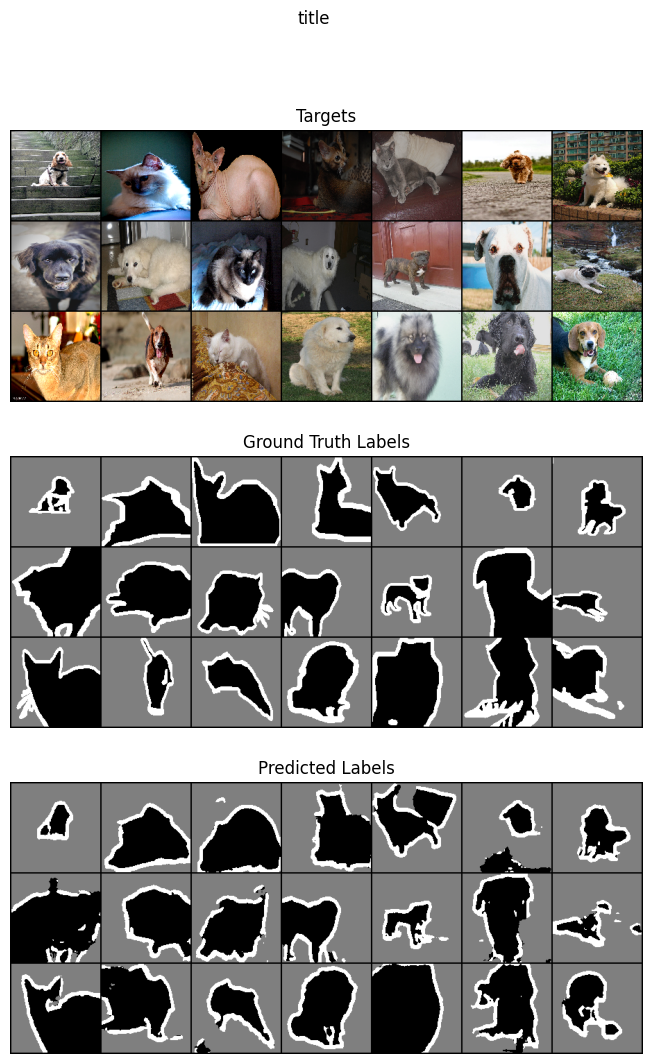

In [20]:
model.eval()
test_inp, test_target = next(iter(pets_test_loader))
test_inp, test_target = test_inp.to(device), test_target.to(device)
predictions = model(test_inp)
pred_labels = predictions.argmax(dim=1)
pred_labels = pred_labels.unsqueeze(1)
mask = pred_labels.to(torch.float)

from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10, 12))
fig.suptitle("title", fontsize=12)

fig.add_subplot(3, 1, 1)
plt.imshow(transforms.ToPILImage()(torchvision.utils.make_grid(test_inp, nrow=7)))
plt.axis('off')
plt.title("Targets")

fig.add_subplot(3, 1, 2)
plt.imshow(transforms.ToPILImage()(torchvision.utils.make_grid(test_target.float() / 2.0, nrow=7)))
plt.axis('off')
plt.title("Ground Truth Labels")

fig.add_subplot(3, 1, 3)
plt.imshow(transforms.ToPILImage()(torchvision.utils.make_grid(mask / 2.0, nrow=7)))
plt.axis('off')
plt.title("Predicted Labels")

plt.show()